# Density simulation of a path-dependent McKean-Vlasov SDE with linear interaction


> This notebook implements the simulations described in Section 2.1.1 of
  - [1] Bernou, A. and Liu, Y. (2024). Particle method for numerical simulation of the path-dependent McKean-Vlasov equation

-------------------------------

**Contents**

* [1. Definition of the McKean-Vlasov equation, the particle system and the Euler scheme](#chapter1)

* [2. Application: Simulation with fixed M](#chapter2)

* [3. Application: Simulation with M depending on N](#chapter3)




-------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from joblib import Parallel, delayed
import time
import shutil
from functools import partialmethod

import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## I. Definition of the McKean-Vlasov equation, the particle system and the Euler scheme <a class="anchor" id="chapter1"></a>


We consider a stochastic process $(X_t)_{t\in[0, T]}$ defined by the following McKean-Vlasov SDE with linear interaction

$$dX_t = - \frac{1}{t} \int_0^t  \int_{\mathbb{R}}(X_t-x)\mu_s(dx) \, ds \, dt+dB_t\quad \text{with}\quad X_0\sim \mathcal{N}(3, \frac{1}{2}),\hspace{2cm}(1)$$

where for every  $t\in[0,T]$, $\mu_t$ denotes the probability distribution of $X_t$.  This process $(X_t)_{t\in[0, T]}$ is a stationary Ornstein-Uhlenbeck process, namely, for every $t\in[0,T], \; \mu_t=\mathcal{N}(3, \frac{1}{2})$ (see [1, Proposition 2.1]).

Let $N$ be the number of particles. The $N$-particle system $(X_t^{1}, ..., X_t^{N})_{t\in[0,T]}$ corresponding to (1) is defined as follows :


\begin{equation}
dX_t^{n}=- \frac{1}{t} \int_0^t \frac{1}{N} \sum_{i=1}^{N}\big(X_t^{n}-X_s^{i}\big) ds \, dt+ B_t^{n}.\hspace{2cm}(2),
\end{equation}
where, for all $n \in \{1,\dots,N\}$, $(B^n_t)_{t \ge 0}$ is a standard Brownian motion.

Let $M$ denote the time discretization number for the Euler scheme. Set $h=\frac{T}{M}$ and $t_m=m\cdot h, 0\leq m\leq M$. Combining the particle system (2) and the Euler scheme, we obtain the following discrete particle system (see also [1, Definition 1.4]): for $1 \le n \le N$,

\begin{equation}
X^n_{t_1} = X^n_0 + \frac{h}{N} \sum_{i=1}^N \big(X^i_{t_0} - X^n_{t_0}\big) +  \sqrt{h} Z^n_1
\end{equation}
and for $1 \le m \le M-1$,
\begin{align}
X^n_{t_{m+1}} &= X^n_{t_m} + \frac{h^2}{2t_{m} N} \sum_{i=1}^N \big( X^i_{t_0} + X^{i}_{t_{m}} \big) - h X^n_{t_m} \\
&\qquad + \frac{h^2}{t_m N} \sum_{i=1}^N \sum_{k=1}^{m-1} X^i_{t_k} + \sqrt{h} Z^n_{m+1},
\end{align}
where $ \: Z_{m+1}^{n}:=\frac{1}{\sqrt{h}}(B^n_{t_{m+1}}-B^n_{t_{m}})$ are i.i.d random variables having the standard normal distribution $\mathcal{N}(0,1)$. Note in particular that the drift implemented numerically also fits the discretization of a truncated drift which satisfies Assumption (II) with $\gamma = 1$ in [1], as the singularity at $t = 0$ has been removed.

* We fix $T = 1$ throughout this notebook.

In [ ]:
# Parameters

T=1.
M=5000  # Time discretization number, adapted in the next sections.
h=T/M  # Time step

m_X0=3  # Mean of the distribution of X_0

In the next cell, the function `Euler_one_step` defines the operator of the Euler scheme for one time step.

In [ ]:
def Euler_first_step(X_in, N_in, h):
    nn=np.ones(N_in)/N_in
    t_1 = h

    EXin=np.matmul(nn, X_in[:,0])
    X_in[:, 1] = X_in[:,0] + h*(EXin - X_in[:,0]) + np.sqrt(h)*np.random.normal(0, 1, N_in)
    return X_in[:,1]

def Euler_one_step(step_in,X_in,N_in, h):
    nn=np.ones(N_in)/N_in
    t_in = step_in*h
    EXin=np.matmul(np.transpose(X_in), nn)
    X_out=(1-h)*X_in[:, step_in]+ (h**2/(2*t_in))*(EXin[0] + EXin[step_in]) + (h**2/(t_in))*(np.sum(EXin[1:step_in-1])) +np.sqrt(h)*np.random.normal(0, 1, N_in)
    return X_out

# II/ Application: Simulation with fixed $M$. <a class="anchor" id="chapter2"></a>
The code of this section is the one used to generate [1, Figure 1].

By default, this section is set with parameter $M=10000$.

Modifying the parameters with $M = 100$, $pn = 11$ and $base = 9$ below, this code can also generate [1, Figure 3].

## 1) Simulation of the particle system

In [3]:
## Parameters
T=1.
M=10000  # Time discretization number, adapted in the next sections.
h=T/M  # Time step
m_X0=3
pn = 7
base = 9
N_power=np.linspace(base,base+pn-1,pn)
N_vec=2**N_power.astype(int)
print("M=", M)
print("Vector of the number of particles", N_vec)

M= 100
Vector of the number of particles [   512   1024   2048   4096   8192  16384  32768  65536 131072 262144
 524288]


First, we compute and save the particle systems at time T=1 with different particle numbers in `N_vec`. For each given particle number, we implement 30 identical and independent simulations.

In [4]:
def one_sim(particle_num, repeat, M, h):
  particle_process=np.zeros((particle_num,M+1))
  particle_process[:,0]=np.random.normal(m_X0, np.sqrt(1/2), particle_num)
  particle_process[:,1]=Euler_first_step(particle_process,particle_num, h)
  #np.savetxt("particle_num_"+str(particle_num)+"repeat"+str(repeat)+"step"+str(0)+".csv", particle_process[:,0], delimiter=",")
  #np.savetxt("particle_num_"+str(particle_num)+"repeat"+str(repeat)+"step"+str(1)+".csv", particle_process[:,1], delimiter=",")

  for m in range(1,M):
    particle_process[:,m+1]=Euler_one_step(m, particle_process,particle_num,h)
  path = "particle_num_"+str(particle_num)+"repeat"+str(repeat)+"step"+str(M)+".csv"
  np.savetxt(path, particle_process[:,M], delimiter=",")
  ## If new simulations, please save somewhere else than the destination path below, as we have there the clean data saved.
  ## COMPLETE IN THE SECOND LINE INFORMATION ABOUT THE PATH TO SAVE THE DATA
  source_path = path
  #destination_path = '/content/drive/My Drive/Results_McKean_N55/'+path
  shutil.move(source_path, destination_path)


In [ ]:
# Parallel simulation to run the Monte-Carlo iterations.

## Please check the destination_path in the cell above before running this cell
NNs = 30

start = time.time()
for i in range(pn):
      print("Step"+str(i)+", M = "+str(M)+", N = "+str(N_vec[i]))
      Parallel(n_jobs = 4)(delayed(one_sim)(N_vec[i], j, M, h) for j in tqdm(range(NNs)))
end = time.time()
print(end-start)


The following cell defines the true density function of $X_t$ for every $t\in[0,T]$, which is the density function of the normal distribution $\mathcal{N}(3,\frac{1}{2})$, see [1, Proposition 2.1].

In [5]:
# Definition of the true density function

def density_true(x_in):
    return norm.pdf(x_in,m_X0,np.sqrt(1/2))


## 2) Estimation of the Wasserstein distance

In the next cells, we compute an empirical Wasserstein distance, using
$$ \mathcal{W}_2(\mu,\nu)^2 = \int_0^1 \Big|F_\mu^{-1}(q) - F_\nu^{-1}(q) \Big|^2 \, d q. $$
We start by computing the vector of theoretical quantiles for the target distribution in the next cell. Since we cannot compute the full integral with quantiles over $[0,1]$  as this gives infinite values, we use a truncation parameter epsilon.

In [6]:
def estim_Wp(a,b, epsilon,p): ## takes two vectors of values and compute the estimated integral.
    n = len(a)
    res = ((1-2*epsilon)/n)*(((a[0] - b[0])**p + (a[-1]+b[-1])**p)/2 + np.sum((a[1:-1] - b[1:-1])**p))
    return(res)

In [7]:
epsilon = 10**(-6) ##
p = 2
NNs = 30
precision_integral = 10**6 ## This parameter is used for the integral discretization
quantile_vector = np.arange(0.01,1,1/precision_integral)
quantile_theoretical = norm.ppf(quantile_vector, 3, np.sqrt(1/2))
error_basic = np.zeros((pn, NNs))
max_error = np.zeros((pn, NNs))
error_final = np.zeros(pn)
for i in tqdm(range(pn)):   ## particle number
    for nns in range(NNs):  ## Monte-Carlo repetition
        ## CHANGE THE SECOND LINE below to access data stored somewhere else.
        path = "particle_num_"+str(N_vec[i])+"repeat"+str(nns)+"step"+str(M)+".csv"
        density_particle= np.array(pd.read_csv("/content/drive/My Drive/Results_McKean_M100/"+path, sep=',',header=None))

        ## Estimation of the Wasserstein distance with respect to the true distribution.
        quantile_method = np.quantile(density_particle, quantile_vector)
        error_basic[i, nns] = estim_Wp(quantile_method, quantile_theoretical, epsilon, p)

    ### Computing the finate global error
    error_final[i] = np.mean(error_basic[i,:]**p)








100%|██████████| 11/11 [2:13:28<00:00, 728.07s/it] 


---------------------------------------

The next cell shows the log-log error curve of the density simulation with the Gaussian kernel.

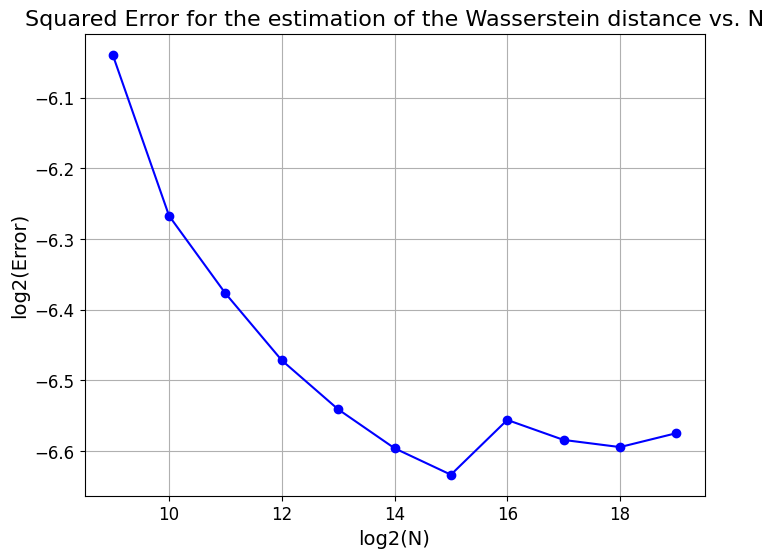

In [8]:
plt.figure(figsize=(8,6))
plt.plot(np.log2(N_vec),np.log2(np.sqrt(error_final)), color = "blue", marker = "o")

plt.xlabel('log2(N)', fontsize=14) # Adjust fontsize as needed
plt.ylabel('log2(Error)', fontsize=14) # Adjust fontsize as needed
plt.title('Squared Error for the estimation of the Wasserstein distance vs. N', fontsize=16) # Adjust fontsize as needed
plt.grid(True)

# Increase tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

The least-square estimate of the slope of the above curve is the following.

In [9]:
X=np.log2(N_vec).reshape(-1,1)
y=np.log2(np.sqrt(error_final))
reg_Gaussian = LinearRegression().fit(X, y)
print ("The estimate of the slope is", reg_Gaussian.coef_)
print ("The estimate of the intercept is", reg_Gaussian.intercept_)


The estimate of the slope is [-0.04427027]
The estimate of the intercept is -5.855978730497368


# III/ Simulation with $M = N^\alpha$. <a class="anchor" id="chapter3"></a>

## 1) Simulation

The code of this section is used to generate [1, Figure 2].

In [ ]:
# Parameters

T=1.
m_X0=3  # Mean of the distribution of X_0
pn=10
base = 9
alpha = .55
N_power=np.linspace(base,base+pn-1,pn)
print (N_power)
N_vec=2**N_power.astype(int) # Number of particles, from 2^7 to 2^15
M_vec = np.rint(N_vec**(alpha))
print(N_vec)
print(M_vec)

[ 9. 10. 11. 12. 13. 14. 15. 16. 17. 18.]
[   512   1024   2048   4096   8192  16384  32768  65536 131072 262144]
[ 31.  45.  66.  97. 142. 208. 304. 446. 653. 955.]


In [ ]:
## Check the destination path in the function one_sim below before executing this cell

NNs = 30

start = time.time()
for i in range(pn):
      M = M_vec[i].astype(int)
      h = T/M
      print("Step"+str(i)+", M = "+str(M)+", N = "+str(N_vec[i]))
      Parallel(n_jobs = 4)(delayed(one_sim)(N_vec[i], j, M, h) for j in tqdm(range(NNs)))
end = time.time()
print(end-start)


Step0, M = 31, N = 512


100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


Step1, M = 45, N = 1024


100%|██████████| 30/30 [00:12<00:00,  2.48it/s]


Step2, M = 66, N = 2048


100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Step3, M = 97, N = 4096


100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


Step4, M = 142, N = 8192


100%|██████████| 30/30 [00:18<00:00,  1.66it/s]


Step5, M = 208, N = 16384


100%|██████████| 30/30 [00:33<00:00,  1.10s/it]


Step6, M = 304, N = 32768


100%|██████████| 30/30 [01:27<00:00,  2.91s/it]


Step7, M = 446, N = 65536


100%|██████████| 30/30 [04:52<00:00,  9.74s/it]


Step8, M = 653, N = 131072


100%|██████████| 30/30 [17:46<00:00, 35.54s/it]


Step9, M = 955, N = 262144


100%|██████████| 30/30 [1:06:13<00:00, 132.44s/it]


## 2) Estimation of the Wasserstein distance

In [ ]:
epsilon = 10**(-6) ## can't compute int_0^1 with quantiles as this gives infinite values
# epsilon is the truncation value
p = 2
NNs = 30
pn = 10
precision_integral = 10**6
quantile_vector = np.arange(0.01,1,1/precision_integral)
quantile_theoretical = norm.ppf(quantile_vector, 3, np.sqrt(1/2))
error_basic = np.zeros((pn, NNs))
max_error = np.zeros((pn, NNs))
error_final = np.zeros(pn)
for i in tqdm(range(pn)):   ## particle number
    for nns in range(NNs):  ## Monte-Carlo repetition
        M = int(M_vec[i])
        h = T/M
        #print("N = "+str(N_vec[i])+", M = "+str(M))
        ## Change the second line below to access data stored somewhere else.
        path = "particle_num_"+str(N_vec[i])+"repeat"+str(nns)+"step"+str(M)+".csv"
        density_particle= np.array(pd.read_csv("/content/drive/My Drive/Results_McKean_N55/"+path, sep=',',header=None))
        ## We have NNs simulations with 2^7 particles for instance. Here we upload the last iteration (result at time T).
        ## Let us estimate the Wasserstein distance with respect to the true distribution.
        quantile_method = np.quantile(density_particle, quantile_vector)
        error_basic[i, nns] = estim_Wp(quantile_method, quantile_theoretical, epsilon, p)

    ### Computing the finate global error
    error_final[i] = np.mean(error_basic[i,:]**p)

100%|██████████| 10/10 [36:24<00:00, 218.42s/it]


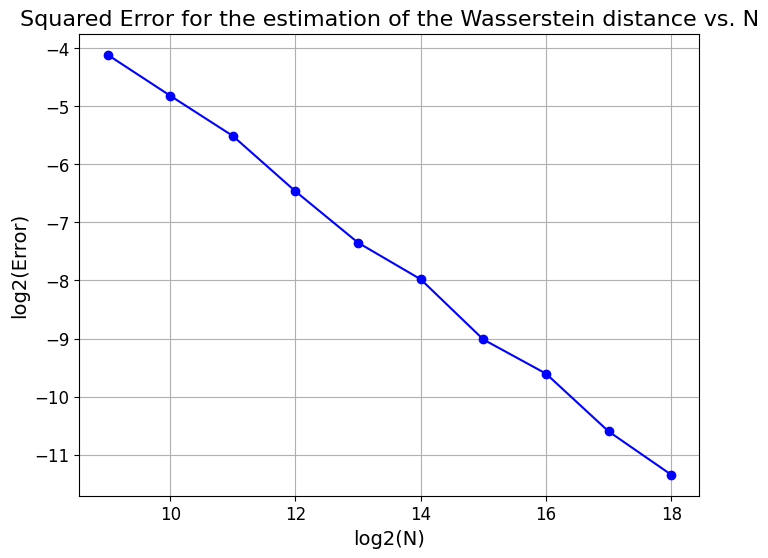

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(np.log2(N_vec),np.log2(np.sqrt(error_final)), color = "blue", marker = "o")

plt.xlabel('log2(N)', fontsize=14) # Adjust fontsize as needed
plt.ylabel('log2(Error)', fontsize=14) # Adjust fontsize as needed
plt.title('Squared Error for the estimation of the Wasserstein distance vs. N', fontsize=16) # Adjust fontsize as needed
plt.grid(True)

# Increase tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [ ]:
X=np.log2(N_vec).reshape(-1,1)
y=np.log2(np.sqrt(error_final))
reg_Gaussian = LinearRegression().fit(X, y)
print ("The estimate of the slope is", reg_Gaussian.coef_)
print ("The estimate of the intercept is", reg_Gaussian.intercept_)

The estimate of the slope is [-0.81403998]
The estimate of the intercept is 3.309005772231089
